# **CASO DE ESTUDIO AGRUPAMIENTO: Reto Digitalización 3 - Fallas en Red Eléctrica**

A partir de los datos de sus clientes, se desea conocer si alguno de los datos tomados por un medidor representa un fallo en la red eléctrica para tomar acciones correctivas en el menor tiempo posible.

# Metodología ASUM-DM

1. Entendimiento del negocio: La empresa energética busca conocer el estado de su red eléctrica para tomar acciones correctivas en caso de ser necesario.

2. Entendimiento analítico: Diseñar un experimento que permita agrupar en una cantidad específica de grupos las mediciones de estaciones en la red eléctrica para determinar si se deben aplicar acciones correctivas. 

3. Requemiento de datos: Se requieren datos de las estaciones de medida que incluyan voltaje rms, corriente rms, consumo energético y frecuencia idealmente. El mínimo requisito es el consumo energético.

4. Recolección de datos: Se tiene un primer dataset de 401 clientes reales tomados en Colombia en zonas de estratos 3 y 4, donde se incluye el id del medidor, la fecha de la muestra y el consumo energético en KWh. 

5. Entendimiento de los datos:
- Identificar la existencia de datos nulos
- Exploración univaridad de los datos
- Exploración multivariada de los datos
- Identificación de correlación y multicolinealidad

In [1]:
#Librerías
##Tratamiento estructurado de datos

import pandas as pd
import numpy as np

##Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

##Advertencias
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/medidores_EIA.csv', sep=';') #Lectura del archivo CSV
data

,ID,FECHA,KWH_IMPORT
0,MED_399,2024-01-04,"1310,28"
1,MED_399,2024-01-16,"1358,004"
2,MED_399,2024-01-29,"1412,016"
3,MED_4,2024-01-09,"745,201"
4,MED_4,2024-01-11,"745,201"
...,...,...,...
143873,MED_375,2024-12-08 00:00:00,"2743,368"
143874,MED_50,2024-12-01 00:00:00,"403,314"
143875,MED_366,2024-12-26 00:00:00,"193,289"
143876,MED_287,2024-12-19 00:00:00,"854,451"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          143878 non-null  object
 1   FECHA       143878 non-null  object
 2   KWH_IMPORT  143878 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [4]:
#Cambiar KWH_IMPORT a float
data['KWH_IMPORT'] = data['KWH_IMPORT'].str.replace(',', '.').astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          143878 non-null  object 
 1   FECHA       143878 non-null  object 
 2   KWH_IMPORT  143878 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


In [5]:
#Desagregar columna de fecha (año-mes-día) en tres columnas separadas tipo int64
data['FECHA'] = pd.to_datetime(data['FECHA'].str.slice(0,10), format='%Y-%m-%d')
data['AÑO'] = data['FECHA'].dt.year.astype('int64')
data['MES'] = data['FECHA'].dt.month.astype('int64')
data['DÍA'] = data['FECHA'].dt.day.astype('int64')
data.head()

,ID,FECHA,KWH_IMPORT,AÑO,MES,DÍA
0,MED_399,2024-01-04,1310.280,2024,1,4
1,MED_399,2024-01-16,1358.004,2024,1,16
2,MED_399,2024-01-29,1412.016,2024,1,29
3,MED_4,2024-01-09,745.201,2024,1,9
4,MED_4,2024-01-11,745.201,2024,1,11


In [6]:
data.tail()

,ID,FECHA,KWH_IMPORT,AÑO,MES,DÍA
143873,MED_375,2024-12-08,2743.368,2024,12,8
143874,MED_50,2024-12-01,403.314,2024,12,1
143875,MED_366,2024-12-26,193.289,2024,12,26
143876,MED_287,2024-12-19,854.451,2024,12,19
143877,MED_28,2024-12-02,1073.851,2024,12,2


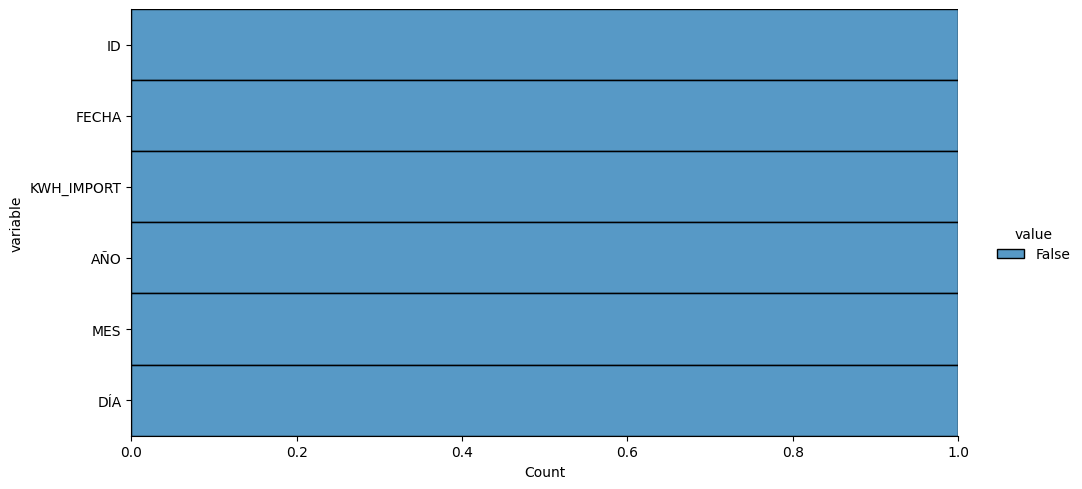

In [7]:
#Visualizar proporción de datos nulos por variable (Se va a visualizar que no hay nulos)
data.isnull().melt().pipe(lambda df: sb.displot(data = df, y = 'variable', hue = 'value', multiple = 'fill', aspect = 2))
plt.show()

### Exploración Univariado
1. Variables de comportamiento único
    - Función de probabilidad uniforme --> Se ignoran

2. Sesgos no naturales de la variable
    - Se habla de desbalances. Si una categoría tiene el 80% o más de la proporción de la variable está desbalanceada --> Se ignoran


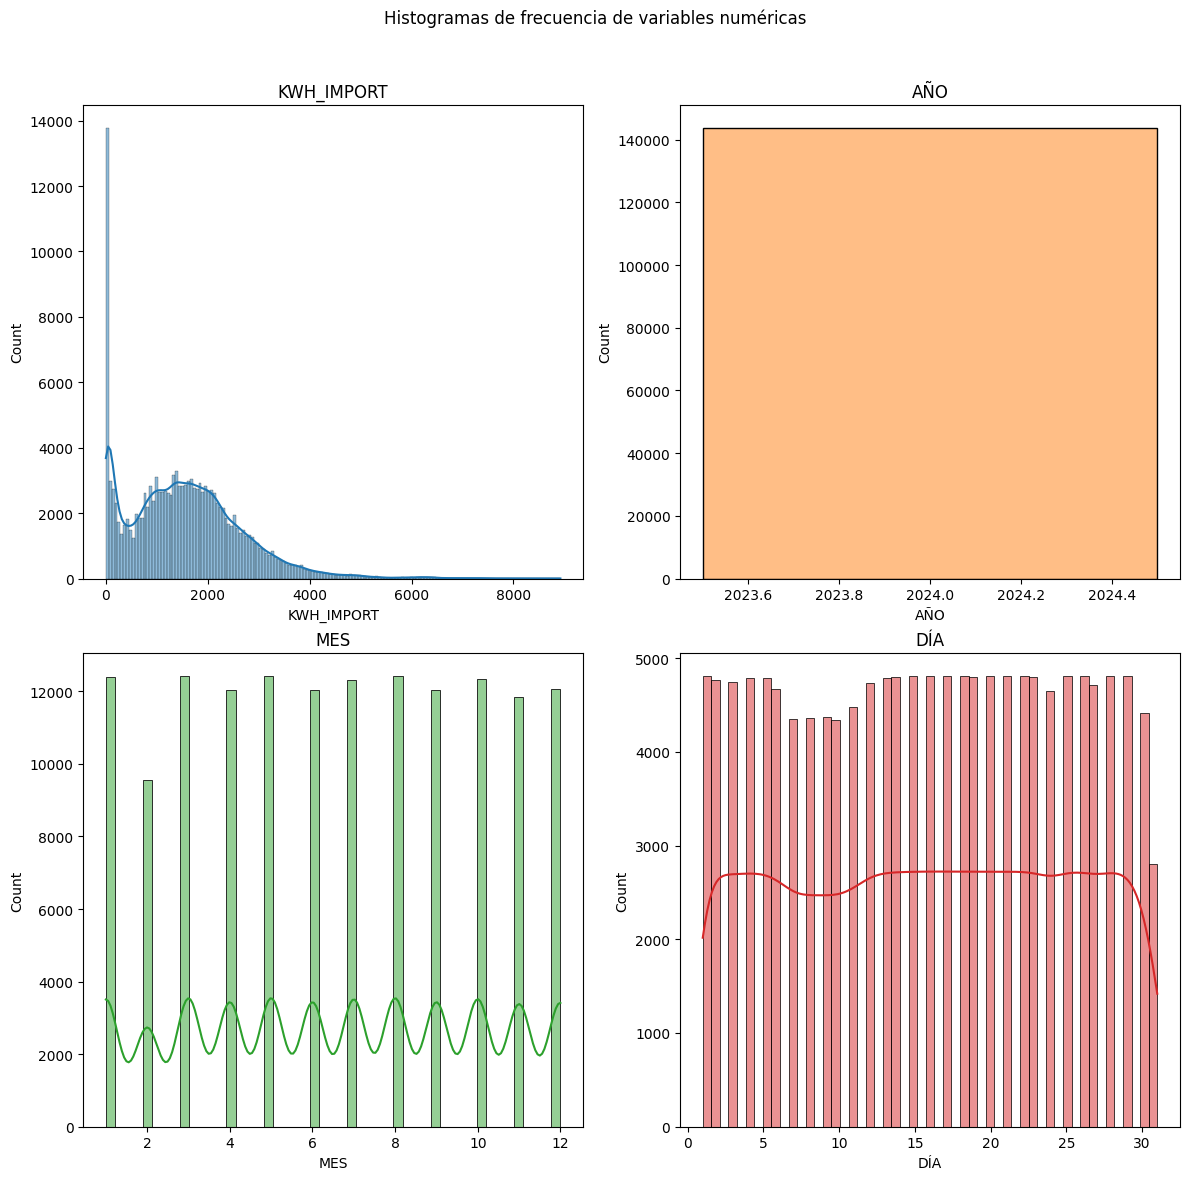

In [10]:
#Exploración univaridad de los datos
##Para datos numéricos: Histogramas de frecuencia
##Para datos categóricos: Gráficos de torta

###HISTOGRAMAS DE FRECUENCIA (Busca variables con distribución uniforme (id) o que no aportan información (Unnamed: 0))
fig,ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flat
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
for i, col in enumerate(num_cols):
    sb.histplot(data = data, x = col, kde = True, 
                color = (list(plt.rcParams['axes.prop_cycle'])*7)[i]['color'], ax = ax[i])
    ax[i].set_title(col)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Histogramas de frecuencia de variables numéricas')
plt.show()


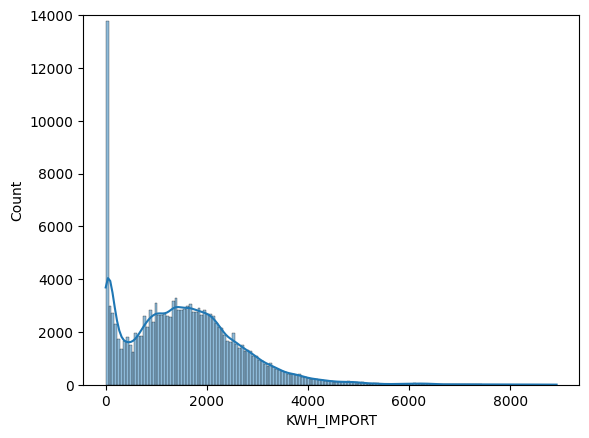

In [11]:
sb.histplot(data = data, x = data['KWH_IMPORT'], kde = True)
plt.ylim(0, 14000)
plt.show()

### Factor de Correlación
Si el comportamiento de una variable depende linealmente de otra variable. -1 <= Factor correlacón <= 1
La fórmula del factor de correlación de Pearson es:

$$
r_{xy} = \frac{\sqrt{(X_1-\bar{X_1})^2(X_2-\bar{X_2})^2}}{\sqrt{(X_1-\bar{X_1})}\sqrt{(X_2-\bar{X_1})}}
$$

donde $x_i$ y $y_i$ son los valores de las variables, $\bar{x}$ y $\bar{y}$ sus medias, y $n$ el número de observaciones.

- *Factor de correlación > 0*: Correlación directa
- *Factor de correlación < 1*: Correlación inversa
- *-0.25 <= Factor de correlación <= 0.25*: Correlación nula
- *0.25 <= |Factor de correlación| <= 0.5*: Correlación débil
- *0.5 <= |Factor de correlación| <= 0.75*: Correlación moderada
- *0.75 <= |Factor de correlación| <= 1*: Correlación fuerte --> Multicolinealidad

> Si se presenta multicolinealidad, se debe ignorar una de las variables. Se ignora la que tenga mayor correlación con las otras variables.

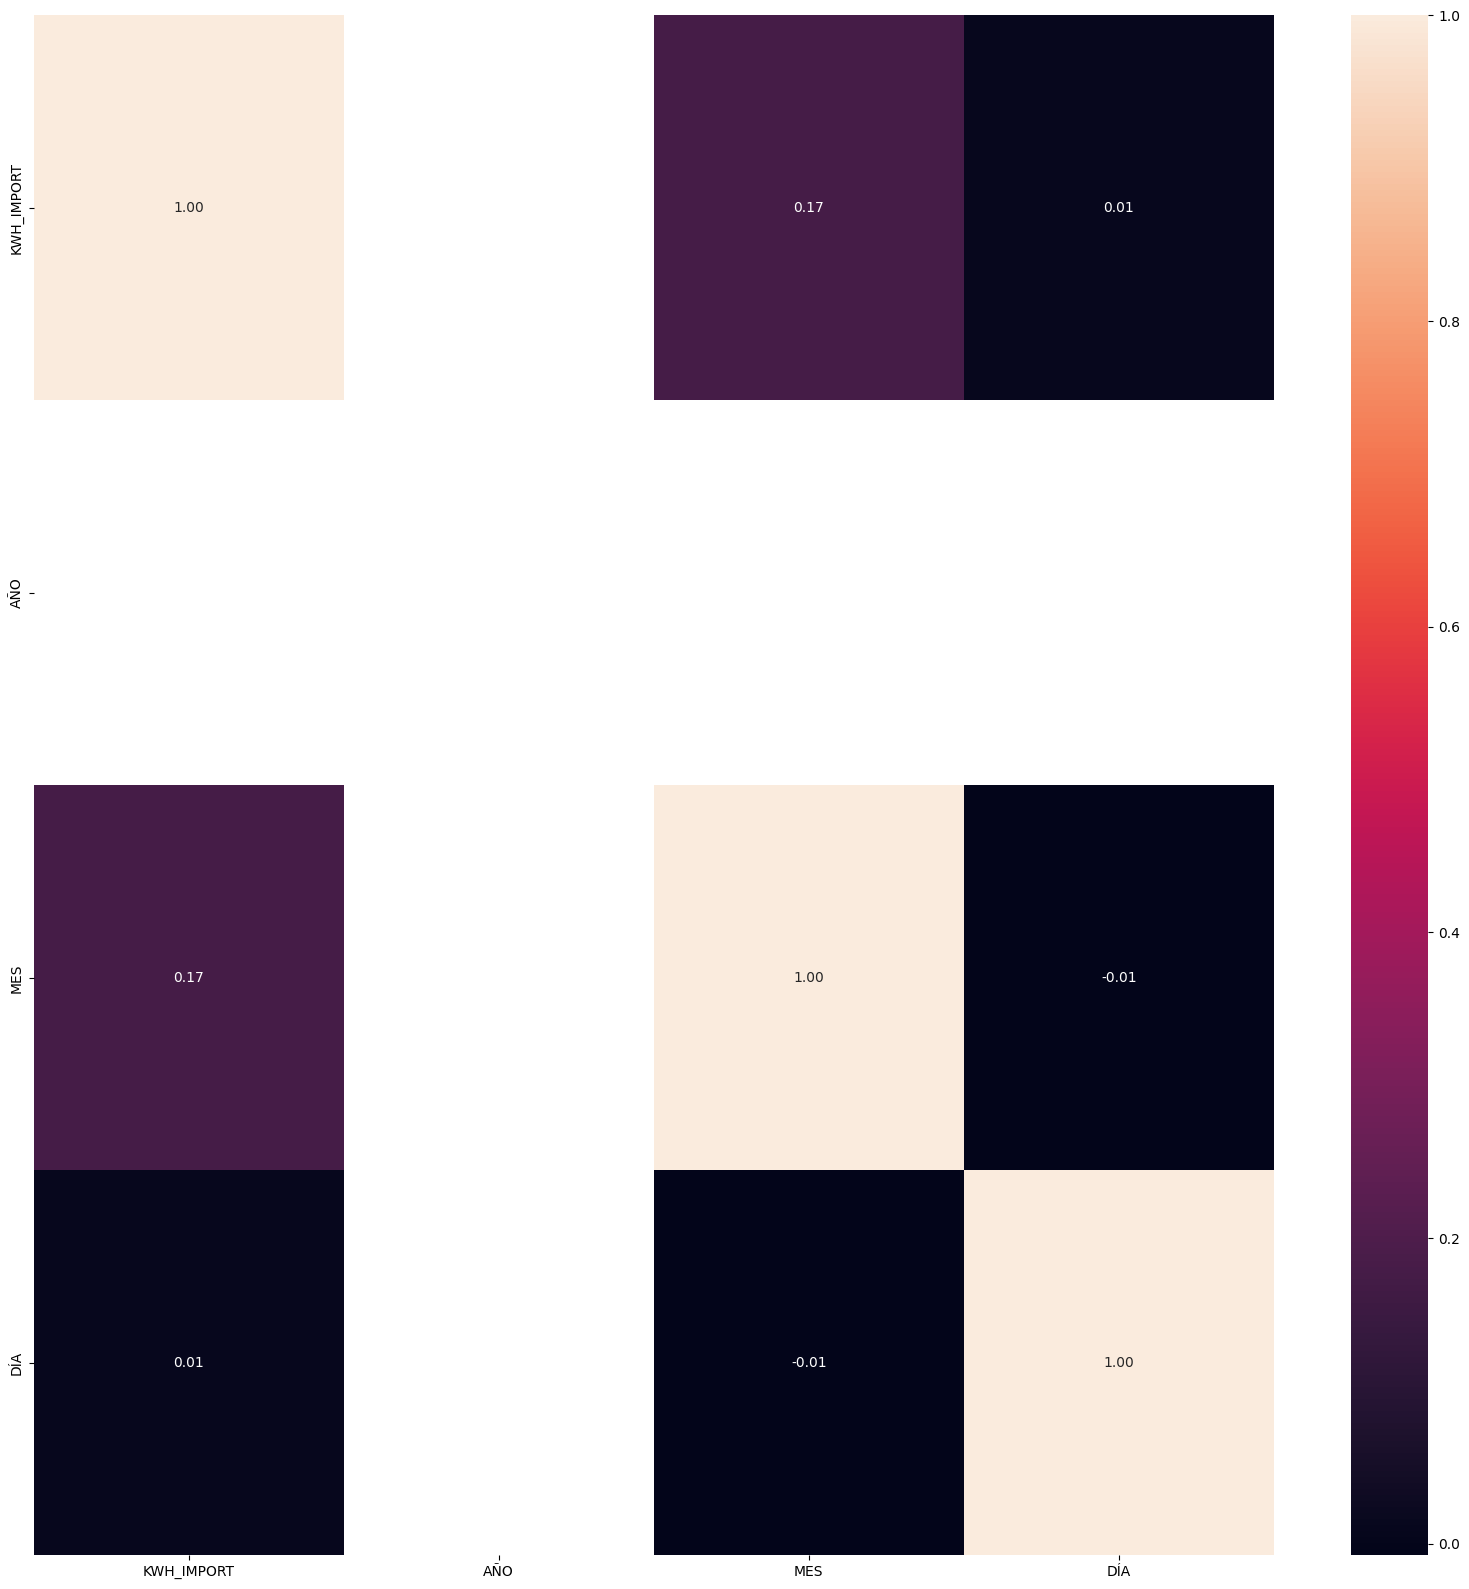

In [12]:
#GRÁFICO DE CORRELACIÓN PARA ANÁLISIS MULTIVARIADO (Busca multicolinealidad)
plt.figure(figsize=(20,20))
sb.heatmap(data = data.corr(numeric_only=True), annot=True, fmt='.2f')
plt.show()

### Conclusiones sobre Variables
- Ignorar FECHA --> Su información fue desagragada
- Ignorar AÑO --> Mismo valor para todos los registros

6. Preparación de los Datos
- Activar las decisiones de ignorar variables
- Transformación de variables para que sean entendibles por el modelo

In [13]:
data_mod = data.drop(['FECHA', 'AÑO'], axis = 1)
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          143878 non-null  object 
 1   KWH_IMPORT  143878 non-null  float64
 2   MES         143878 non-null  int64  
 3   DÍA         143878 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ MB


In [16]:
# Transformación de variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

#Identificar las columnas según su tipo
num_col = data_mod.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_col = data_mod.select_dtypes(include=['object']).columns.to_list()

#Tipo de transformación por tipo de dato
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False))])

#Diseño del transformador de columnas
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_col),
                                               ('cat', cat_transformer, cat_col)],
                                               remainder='passthrough')
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [17]:
data_pre = preprocessor.fit_transform(data_mod)
data_pre

array([[0.14688314, 0.        , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.15223303, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.1582878 , 0.        , 0.93333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02166781, 1.        , 0.83333333, ..., 0.        , 0.        ,
        0.        ],
       [0.09578445, 1.        , 0.6       , ..., 0.        , 0.        ,
        0.        ],
       [0.12037931, 1.        , 0.03333333, ..., 0.        , 0.        ,
        0.        ]], shape=(143878, 404))

In [18]:
cod_cat = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, cod_cat])
data_pro = pd.DataFrame(data_pre, columns=labels)
data_pro.head()
data_pro = data_pro.sample(3000)        # Subsample for faster processing
data_pro

,KWH_IMPORT,MES,DÍA,ID_MED_1,ID_MED_10,ID_MED_100,ID_MED_101,ID_MED_102,ID_MED_103,ID_MED_104,...,ID_MED_90,ID_MED_91,ID_MED_92,ID_MED_93,ID_MED_94,ID_MED_95,ID_MED_96,ID_MED_97,ID_MED_98,ID_MED_99
92722,0.023032,0.636364,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60928,0.079854,0.454545,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62854,0.000739,0.454545,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95394,0.200223,0.636364,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41896,0.004139,0.272727,0.766667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131588,0.249534,0.909091,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26939,0.053546,0.181818,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54573,0.193978,0.363636,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141280,0.182336,1.000000,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7. Construcción del modelo

**K Means**

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

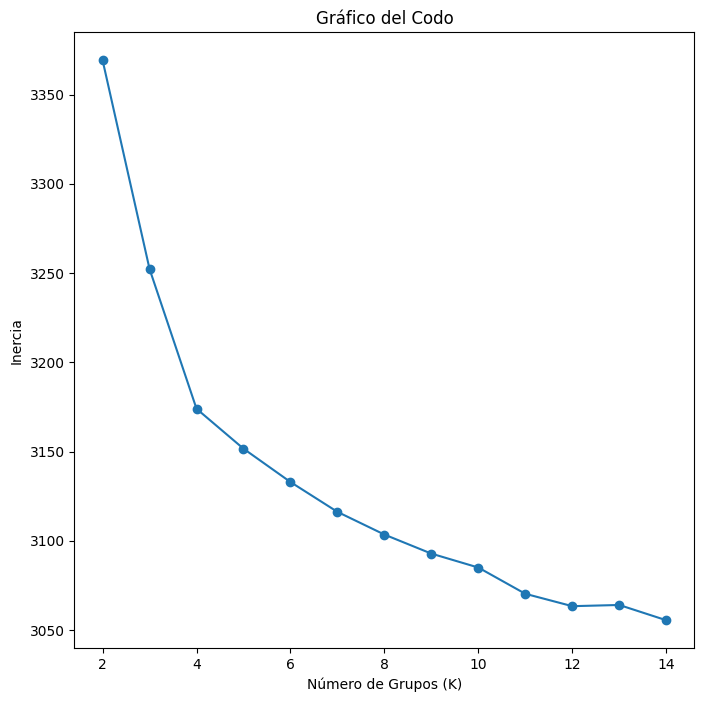

In [26]:
#Buscar el rango para K (busca el codo)
range_k = range(2, 25)
inertia = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    inertia.append(kmean_model.inertia_)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, inertia, marker='o')
plt.title("Gráfico del Codo")
plt.xlabel("Número de Grupos (K)")
plt.ylabel("Inercia")
plt.show()

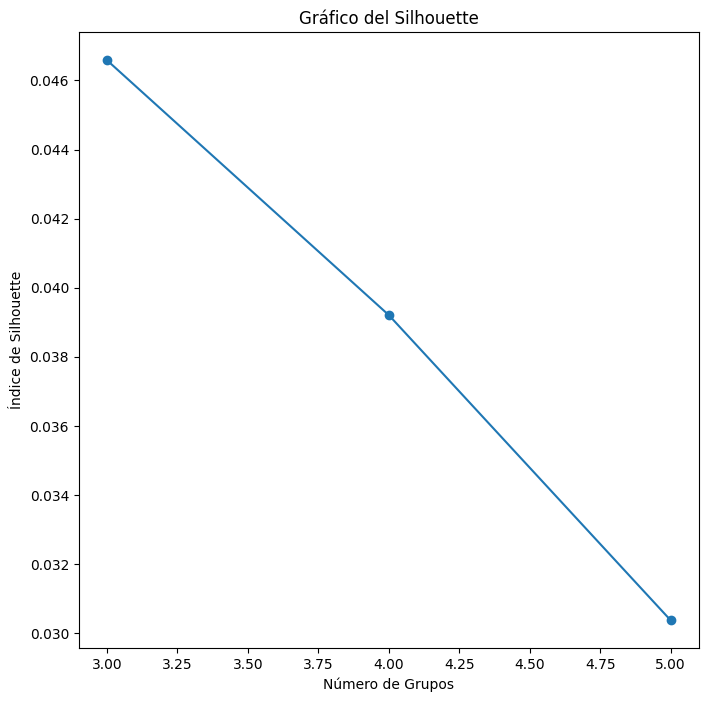

In [28]:
#Búsqueda fina de k (dado el rango de codo, toma el válor de max índice)
range_k = range(3, 6)
sil_score = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    cluster_label = kmean_model.fit_predict(data_pro)
    sil_avg = silhouette_score(data_pro, cluster_label)
    sil_score.append(sil_avg)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, sil_score, marker='o')
plt.title("Gráfico del Silhouette")
plt.xlabel("Número de Grupos")
plt.ylabel("Índice de Silhouette")
plt.show()

In [29]:
# Selección del número óptimo de clusters
k_mean_model_final = KMeans(n_clusters=3, n_init=20, random_state=123)
k_mean_model_final.fit(data_pro)

,n_clusters,3
,init,'k-means++'
,n_init,20
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,123
,copy_x,True
,algorithm,'lloyd'


**Jerárquico Aglomerativo**

In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#Función para dibujar el dendrograma
def dibujarDendrograma(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
 
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
 
    # Plot
    dendrogram(linkage_matrix, **kwargs)

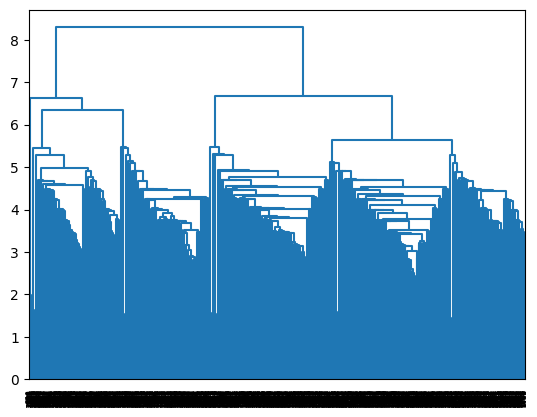

In [30]:
#Varianza
h_clust_ward = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
h_clust_ward.fit(X = data_pro)
dibujarDendrograma(h_clust_ward, color_threshold=0)

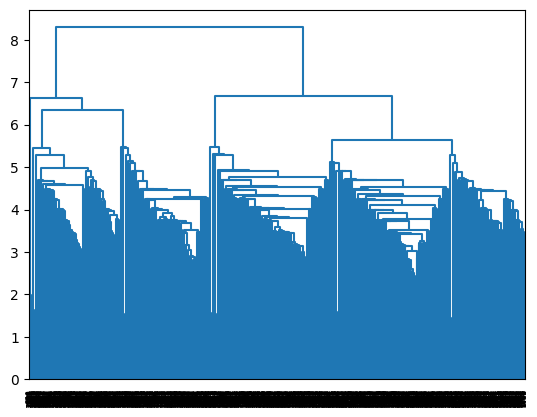

In [31]:
#Promedio
h_clust_average = AgglomerativeClustering(metric='euclidean', linkage='average', distance_threshold=0, n_clusters=None)
h_clust_average.fit(X = data_pro)
dibujarDendrograma(h_clust_ward, color_threshold=0)

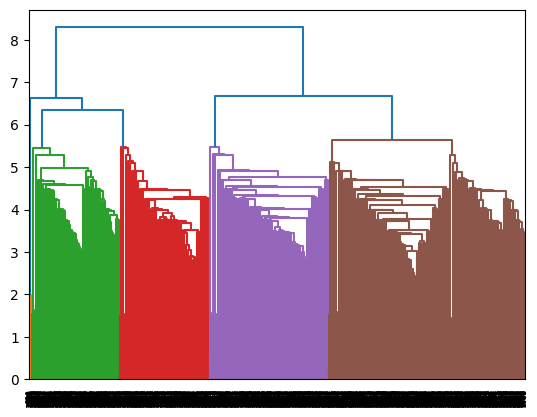

In [32]:
dendogram_prun = 6       #Distancia seleccionada cortando a la mitad la línea más larga del dendrograma
dibujarDendrograma(h_clust_ward, color_threshold=dendogram_prun)

In [33]:
h_clust_final = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=4)
h_clust_final.fit(X = data_pro)

,n_clusters,4
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,None
,compute_distances,False


**DBScan**

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import product

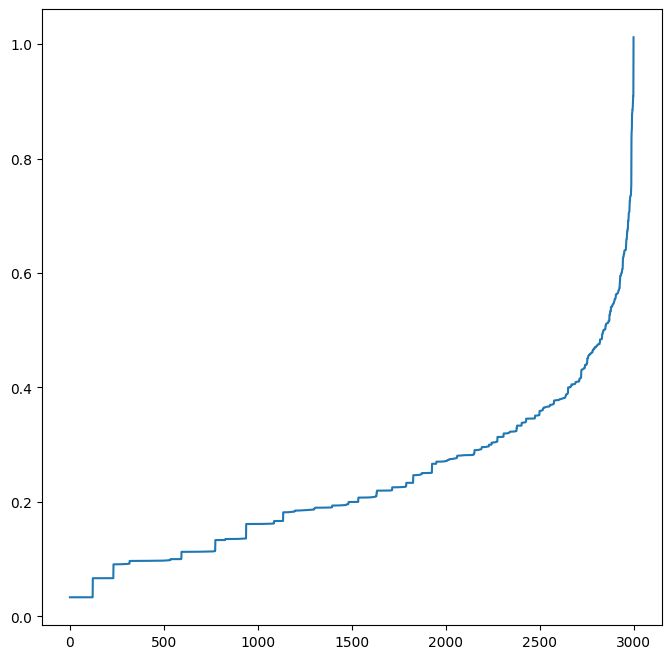

In [35]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(data_pro)
distance, index = neighbors_fit.kneighbors(data_pro)
distance = np.sort(distance, axis=0)
distance = distance[:, 1]
plt.figure(figsize=(8, 8))
plt.plot(distance)

In [36]:
# Ajuste de DBSCAN
eps_values = np.arange(0.6, 1.0, 0.1)
min_samples = np.arange(2, 10, 1)
dbscan_params = list(product(eps_values, min_samples))
sil_score = []
for p in dbscan_params:
    y_pred = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(data_pro)
    sil_score.append(silhouette_score(data_pro, y_pred))
    

<Axes: xlabel='Epsilon', ylabel='Mínimas Muestras'>

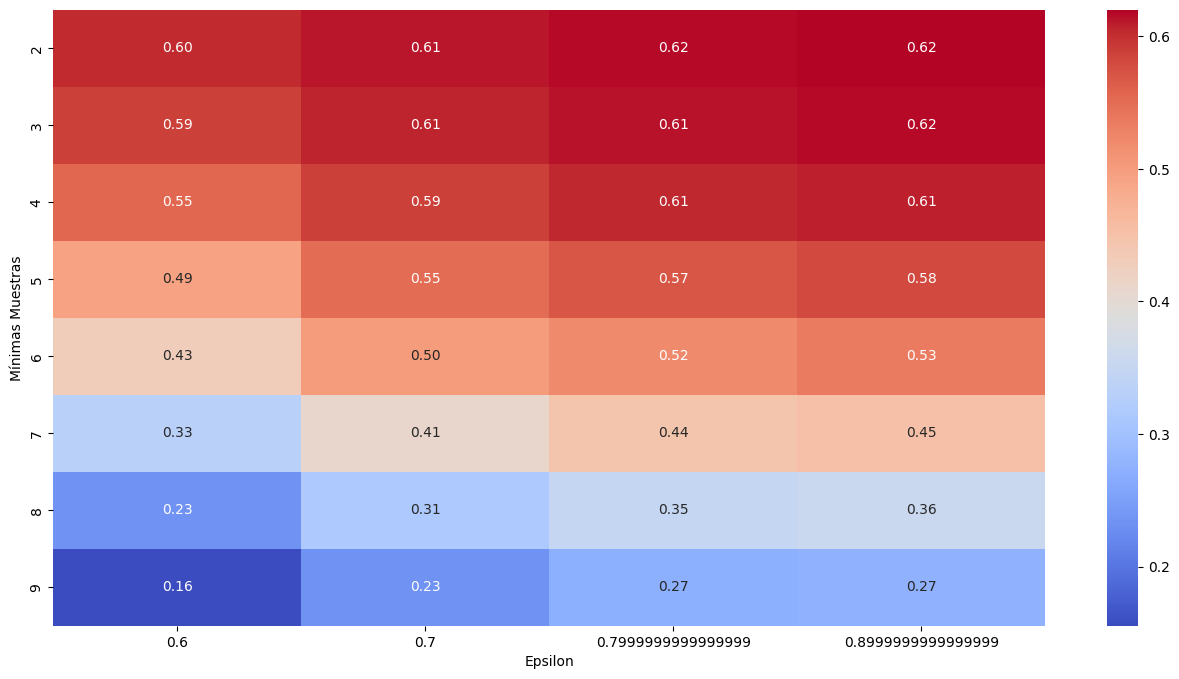

In [37]:
df_param_adj = pd.DataFrame(dbscan_params, columns=['Epsilon', 'Mínimas Muestras'])
df_param_adj['Score'] = sil_score
pivot_data = pd.pivot_table(df_param_adj, values='Score', index='Mínimas Muestras', columns='Epsilon')
plt.figure(figsize=(16, 8))
sb.heatmap(data=pivot_data, annot=True, fmt='.2f', cmap='coolwarm')

## Se debe seleccionar el mejor parámetro de eps y min_samples basado en el score más alto. En caso de score iguales, 
# se debe seleccionar el de menor mínimas muestras

In [38]:
dbscan_final = DBSCAN(eps=0.7, min_samples=2)
dbscan_final.fit(data_pro)

,eps,0.7
,min_samples,2
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


**Gaussian Mixture Models (GMM)**

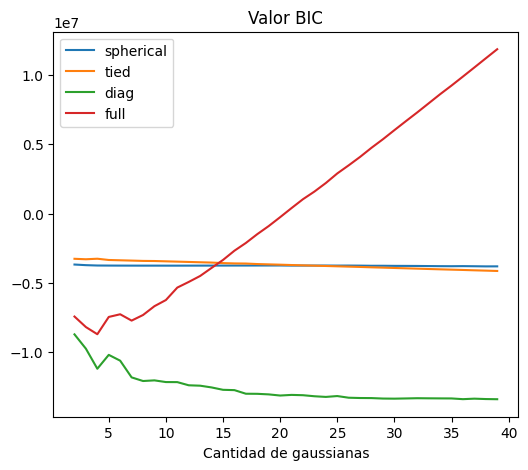

In [39]:
from sklearn.mixture import GaussianMixture
fig, ax = plt.subplots(figsize=(6,5))
n_gauss = range(2, 40)
var_types = ['spherical', 'tied', 'diag', 'full']
''' Spherical: La proyección en 2D es un círculo, la varianza es la misma en todas las direcciones.
    Tied: Misma varianza para todas las gaussianas
    Diagonal: Varianza según una de las variables o características de los datos
    Full: Deja libre la varianza de cada gaussiana, es decir, cada gaussiana puede tener una forma diferente.'''
for covariance_type in var_types:
    valor_bic = []
    for i in n_gauss:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type, random_state=123)
        modelo.fit(data_pro)
        valor_bic.append(modelo.bic(data_pro))
        
    ax.plot(n_gauss, valor_bic, label=covariance_type)
ax.set_title('Valor BIC')
ax.set_xlabel('Cantidad de gaussianas')
ax.legend()
plt.show()
#Se debe serleccionar el mínimo BIC (eje Y) y el número de gaussianas (eje X) que lo produce.

In [40]:
gmm_final = GaussianMixture(n_components=35, covariance_type='diag', random_state=123)
gmm_final.fit(data_pro)

,n_components,35
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,123


8. Evaluación del Modelo

In [41]:
labels_kmeans = k_mean_model_final.predict(data_pro)
labels_hclust = h_clust_final.fit_predict(data_pro)
labels_dbscan = dbscan_final.fit_predict(data_pro)
labels_gmm = gmm_final.predict(data_pro)

In [42]:
sil_kmeans = silhouette_score(data_pro, labels_kmeans)
sil_hclust = silhouette_score(data_pro, labels_hclust)
sil_dbscan = silhouette_score(data_pro, labels_dbscan)
sil_gmm = silhouette_score(data_pro, labels_gmm)
print(f'El índice de Silhouette para:\nKMeans = {sil_kmeans:.2f} \nJerárquico = {sil_hclust:.2f} \nDBScan = {sil_dbscan:.2f} \nGMM = {sil_gmm:.2f}')
#Si DBSCAN tiene un mayor score, es necesario revisar la cantidad de grupos

El índice de Silhouette para:
KMeans = 0.05 
Jerárquico = 0.00 
DBScan = 0.61 
GMM = 0.00


In [43]:
np.unique(labels_dbscan)
#-1 es punto de ruido, los demás son grupos. Se debe contar la cantidad de ruido

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [45]:
data_pro.DBSCAN.value_counts()
# Revisar cantidad de ruido (-1). Este número debe ser bajo.

DBSCAN
-1      27
 104    22
 222    15
 219    15
 68     15
        ..
 332     2
 147     2
 16      2
 397     2
 407     2
Name: count, Length: 409, dtype: int64

In [44]:
data_pro['DBSCAN'] = labels_dbscan